In [1]:
import numpy as np

In [12]:
from scipy.stats import beta
from scipy import integrate

def pdf(p, weights, rewards, normalization=1):
    s = 1
    for weight, reward in zip(weights, rewards):
        if reward == 1:
            s *= (weight * p)
        else:
            s *= (1 - weight * p)
    return s / normalization

def get_expected_mean_std(weights, rewards):
    normalization = integrate.quad(
        lambda x: pdf(x, weights, rewards), 0, 1
    )[0]
    first_order = integrate.quad(
        lambda x: x * pdf(x, weights, rewards, normalization), 0, 1
    )[0]
    second_order = integrate.quad(
        lambda x: x * x * pdf(x, weights, rewards, normalization), 0, 1
    )[0]
    return (first_order, (second_order - first_order ** 2) ** 0.5)

def beta_estimation(weights, rewards):
    trials = len(rewards)
    return (beta.mean(1 + sum(rewards), trials+1 - sum(rewards)),
        beta.std(1 + sum(rewards), trials+1 - sum(rewards)))

In [56]:
trials = 100
discountings = np.zeros(trials)
rewards = np.zeros(trials)

logs = []

for it in range(trials):
    discountings[it] = 0.97**it
    p_k = 0.7 * discountings[it]
    rewards[it] = int(np.random.choice([0, 1], p=(1-p_k, p_k)))
    estimation_bayes = get_expected_mean_std(discountings[:it + 1], rewards[:it + 1])
    estimation_beta = beta_estimation(discountings[:it + 1], rewards[:it + 1])
    logs.append((estimation_bayes, estimation_beta, p_k))

In [57]:
import matplotlib.pyplot as plt
%matplotlib inline

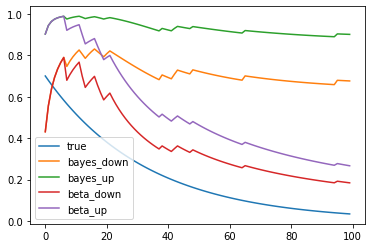

In [58]:
plt.plot([x[-1] for x in logs], label='true')
plt.plot([x[0][0] - x[0][1] for x in logs], label='bayes_down')
plt.plot([x[0][0] + x[0][1] for x in logs], label='bayes_up')
plt.plot([x[1][0] - x[1][1] for x in logs], label='beta_down')
plt.plot([x[1][0] + x[1][1] for x in logs], label='beta_up')
plt.legend()
plt.show()

In [375]:
# with enemy

def run(trials=500, prior_enemy=0.5, prior_reward=0.7):
    discountings = [1]
    discountings_est = [1]
    rewards = []

    logs = []

    enemy_moves = 0

    def enemy_p_estimate(discountings_est, rewards):
#         return get_expected_mean_std(discountings_est, rewards)[0] * (1 - prior_enemy) + \
#             beta_estimation(discountings_est, rewards)[0] * prior_enemy
#         return  beta_estimation(discountings_est, rewards)[0]
        return get_expected_mean_std(discountings_est, rewards)[0]

    for it in range(trials):
        p_k = prior_reward * discountings[-1]
        is_enemy = int(np.random.choice([0, 1], p=(1 - prior_enemy, prior_enemy)))
        enemy_moves += is_enemy
        exact_reward = int(np.random.choice([0, 1], p=(1-p_k, p_k)))
        p_enemy = enemy_p_estimate(discountings_est[:-1], rewards)
        if not is_enemy:
            reward = exact_reward
        else:
            reward = int(np.random.choice([0, 1], p=(1-p_enemy, p_enemy))) #int(np.random.choice([0, 1], p=(1-p_enemy, p_enemy)))
        rewards.append(reward)
        if is_enemy:  # for decay estimation
            reward = (1 - np.exp(np.log(1 - 0.03) * p_enemy)) / 0.03
        estimation_bayes = get_expected_mean_std(discountings_est, rewards)
        alpha = 1#0.5 * (1 + 1/(1 - prior_enemy ** 4))
        estimation_bayes = (estimation_bayes[0] * alpha, estimation_bayes[1] * alpha)
        estimation_beta = beta_estimation(discountings_est, rewards)
        discountings.append(discountings[-1] * (1 - 0.03 * exact_reward))
        discountings_est.append(discountings_est[-1] * (1 - 0.03 * reward))
        estimation_smooth = (
            estimation_bayes[0] * (1 - prior_enemy) + estimation_beta[0] * prior_enemy,
            estimation_bayes[1] * (1 - prior_enemy) + estimation_beta[1] * prior_enemy,
        )
        logs.append((estimation_bayes, estimation_beta, estimation_smooth, p_k))
        
    return logs

In [376]:
def plot_run(logs):    
    def plot_x(name, coord):
        x = np.array([x[coord][0] for x in logs])
        s = np.array([x[coord][1] for x in logs])
        plt.fill_between(np.arange(len(logs)), x - 2 * s, x + 2 * s, 
                     label=name, alpha=0.5)
        

    plot_x('bayes', 0)
    plot_x('beta', 1)
    plot_x('smooth', 2)
    plt.plot([x[-1] for x in logs], label='true_decay')
    plt.plot(np.ones(len(logs)) * logs[0][-1], label='true')
    plt.ylim([-0.1, 1.1])
    plt.legend()
    plt.show()

pr=0.25, pe=0


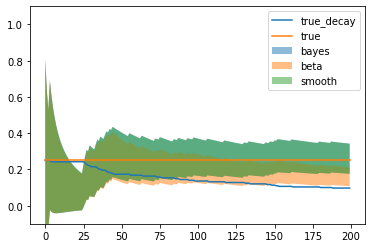

pr=0.25, pe=0.25


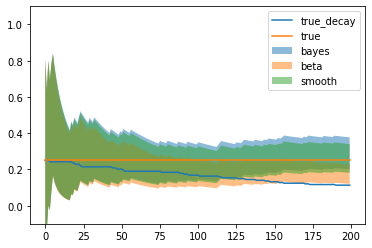

pr=0.25, pe=0.5


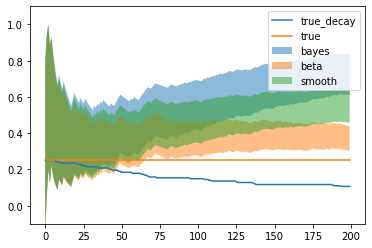

pr=0.25, pe=0.75


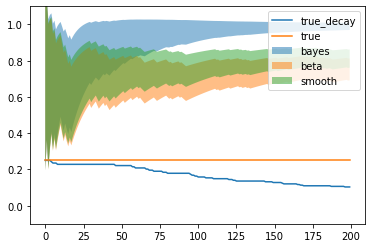

pr=0.25, pe=0.9


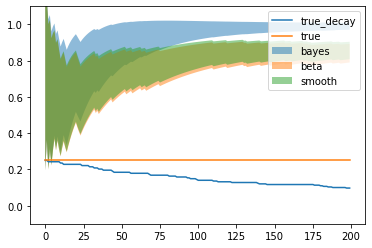

pr=0.5, pe=0


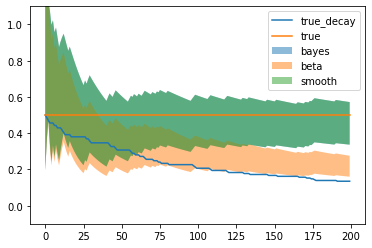

pr=0.5, pe=0.25


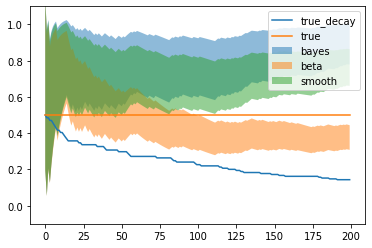

pr=0.5, pe=0.5


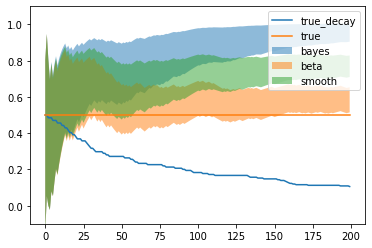

pr=0.5, pe=0.75


/usr/local/lib/python3.9/site-packages/matplotlib/axes/_axes.py:5274: ComplexWarning: Casting complex values to real discards the imaginary part
  pts[0] = start
/usr/local/lib/python3.9/site-packages/matplotlib/axes/_axes.py:5275: ComplexWarning: Casting complex values to real discards the imaginary part
  pts[N + 1] = end
/usr/local/lib/python3.9/site-packages/matplotlib/axes/_axes.py:5278: ComplexWarning: Casting complex values to real discards the imaginary part
  pts[1:N+1, 1] = dep1slice
/usr/local/lib/python3.9/site-packages/matplotlib/axes/_axes.py:5280: ComplexWarning: Casting complex values to real discards the imaginary part
  pts[N+2:, 1] = dep2slice[::-1]
/usr/local/lib/python3.9/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


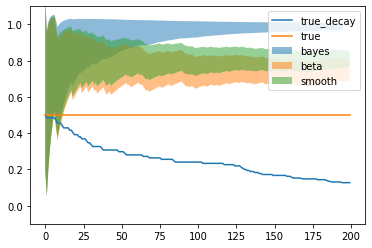

pr=0.5, pe=0.9


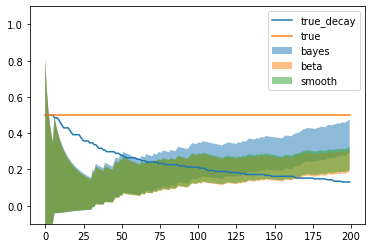

pr=0.75, pe=0


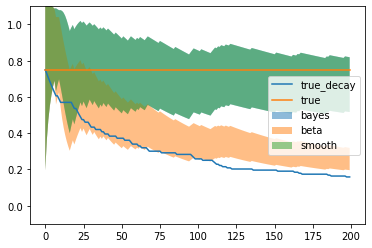

pr=0.75, pe=0.25


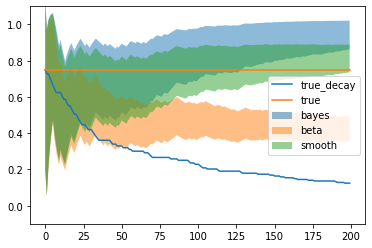

pr=0.75, pe=0.5


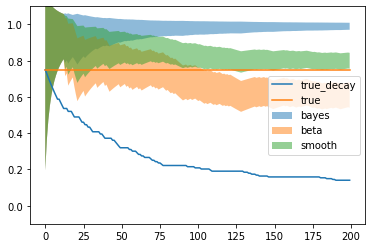

pr=0.75, pe=0.75


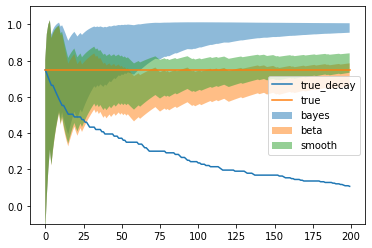

pr=0.75, pe=0.9


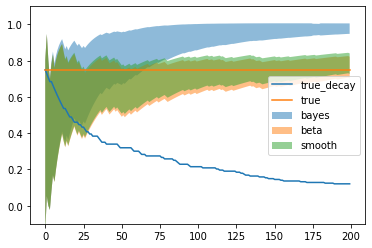

pr=0.95, pe=0


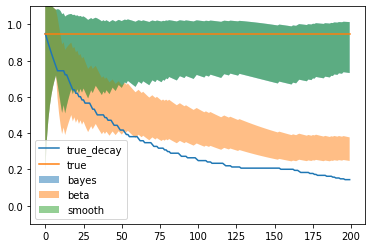

pr=0.95, pe=0.25


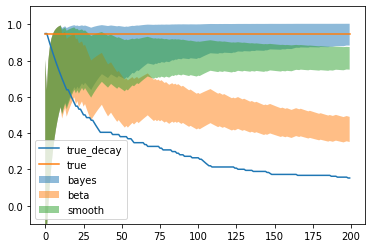

pr=0.95, pe=0.5


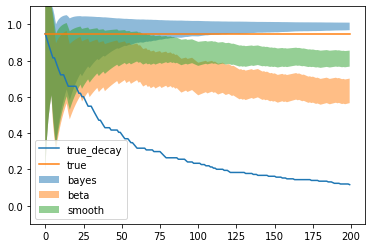

pr=0.95, pe=0.75


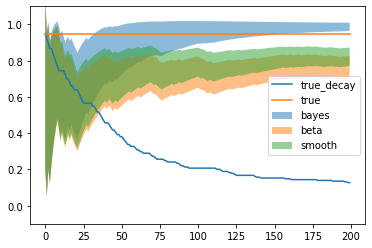

pr=0.95, pe=0.9


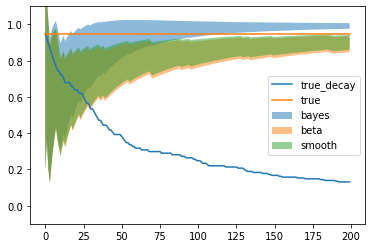

In [377]:
for pr in [0.25, 0.5, 0.75, 0.95]:
    for pe in [0, 0.25, 0.5, 0.75, 0.9]:
        logs = run(trials=200, prior_enemy=pe, prior_reward=pr)
        print('pr={}, pe={}'.format(pr, pe))
        plot_run(logs)